In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

In [2]:
data = pd.read_pickle("../data/transactions.pkl")

X = data.drop(['fraud'],axis=1)
y = data['fraud']

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_valid.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 356785 samples
Validation set size: 118929 samples
Testing set size: 118929 samples


In [6]:
import xgboost as xgb

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)
d_test = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 10,
    'min_child_weight': 257,
    'scale_pos_weight': 9,
    'learning_rate': 0.01,
    'eta': 0.3,
    'lambda': 0.003,
    'alpha': 0.015,
    'gamma': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.55,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr'
}

evals = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(params,
                  d_train,
                  10000,
                  verbose_eval=100,
                  evals=evals,
                  early_stopping_rounds=100)

[0]	train-aucpr:0.76289	valid-aucpr:0.75532
[100]	train-aucpr:0.84678	valid-aucpr:0.83604
[200]	train-aucpr:0.85715	valid-aucpr:0.84767
[300]	train-aucpr:0.86753	valid-aucpr:0.85885
[400]	train-aucpr:0.87354	valid-aucpr:0.86511
[500]	train-aucpr:0.87747	valid-aucpr:0.86939
[600]	train-aucpr:0.88097	valid-aucpr:0.87303
[700]	train-aucpr:0.88396	valid-aucpr:0.87581
[800]	train-aucpr:0.88578	valid-aucpr:0.87694
[900]	train-aucpr:0.88801	valid-aucpr:0.87864
[1000]	train-aucpr:0.88957	valid-aucpr:0.87974
[1100]	train-aucpr:0.89100	valid-aucpr:0.88082
[1200]	train-aucpr:0.89251	valid-aucpr:0.88204
[1300]	train-aucpr:0.89363	valid-aucpr:0.88291
[1400]	train-aucpr:0.89480	valid-aucpr:0.88383
[1500]	train-aucpr:0.89576	valid-aucpr:0.88464
[1600]	train-aucpr:0.89655	valid-aucpr:0.88528
[1700]	train-aucpr:0.89729	valid-aucpr:0.88566
[1800]	train-aucpr:0.89806	valid-aucpr:0.88632
[1900]	train-aucpr:0.89882	valid-aucpr:0.88695
[2000]	train-aucpr:0.89950	valid-aucpr:0.88735
[2100]	train-aucpr:0.9001

In [7]:
y_prob = model.predict(d_test)
y_pred = (y_prob > 0.55).astype(int)

cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test, y_pred))

Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    117512
           1       0.66      0.91      0.76      1417

    accuracy                           0.99    118929
   macro avg       0.83      0.95      0.88    118929
weighted avg       0.99      0.99      0.99    118929

Confusion Matrix of Random Forest Classifier: 
 [[116847    665]
 [   128   1289]]


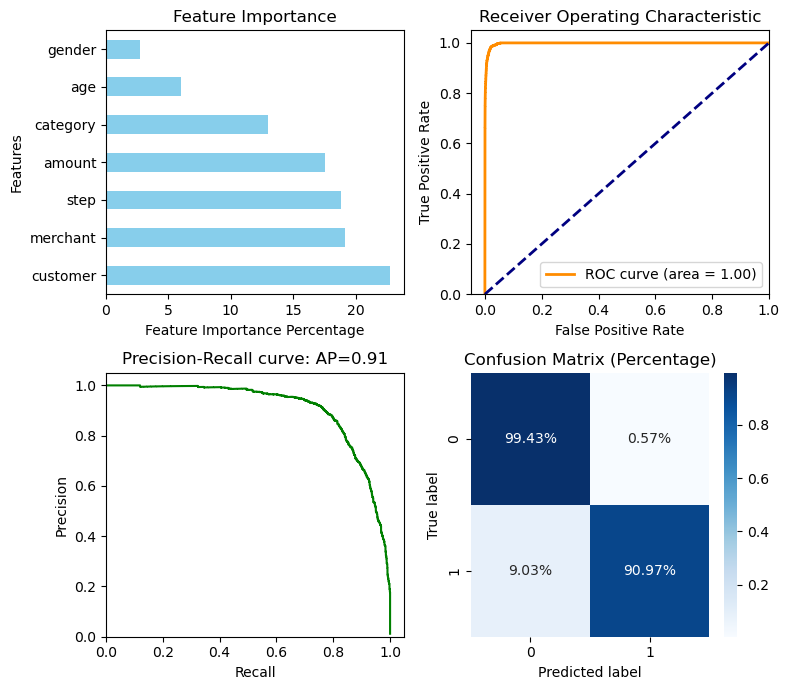

In [8]:
# Get feature importances from the model
importance = model.get_score(importance_type='weight')
importance_df = pd.Series(importance)
importance_df = (importance_df / importance_df.sum()) * 100  # Normalize to percentage
sorted_df = importance_df.sort_values(ascending=False)

# ROC Curve calculation
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve calculation
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

# Confusion Matrix calculation
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

# Plot Feature Importances
sorted_df.plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Feature Importance')
axes[0, 0].set_xlabel('Feature Importance Percentage')
axes[0, 0].set_ylabel('Features')

# Plot ROC Curve
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_xlim([-0.05, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Receiver Operating Characteristic')
axes[0, 1].legend(loc="lower right")

# Plot Precision-Recall Curve
axes[1, 0].step(recall, precision, where='post', color='green')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlim([0.0, 1.05])
axes[1, 0].set_title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Plot Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix (Percentage)')
axes[1, 1].set_xlabel('Predicted label')
axes[1, 1].set_ylabel('True label')

# Adjust layout
plt.tight_layout()
plt.show()